### Evaluation

In [1]:
import os
from PIL import Image
import torch
import numpy as np

In [2]:
DATA_PATH = "../../../Data.nosync/"
model_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/e4e/test649437/checkpoints/iteration_0.pt"

In [3]:
os.chdir('../../encoder4editing/')

In [4]:
from utils.model_utils import setup_model, load_e4e_standalone
from configs import data_configs, paths_config

net, opts = setup_model(model_path, device = 'cuda')

dataset_args = data_configs.DATASETS[opts.dataset_type]
transforms_dict = dataset_args['transforms'](opts).get_transforms()

Loading e4e over the pSp framework from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/e4e/test649437/checkpoints/iteration_0.pt


In [5]:
encoder = net.encoder
generator = net.decoder
generator.eval()

Generator(
  (style): Sequential(
    (0): PixelNorm()
    (1): EqualLinear(512, 512)
    (2): EqualLinear(512, 512)
    (3): EqualLinear(512, 512)
    (4): EqualLinear(512, 512)
    (5): EqualLinear(512, 512)
    (6): EqualLinear(512, 512)
    (7): EqualLinear(512, 512)
    (8): EqualLinear(512, 512)
  )
  (input): ConstantInput()
  (conv1): StyledConv(
    (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
    (noise): NoiseInjection()
    (activate): FusedLeakyReLU()
  )
  (to_rgb1): ToRGB(
    (conv): ModulatedConv2d(512, 3, 1, upsample=False, downsample=False)
  )
  (convs): ModuleList(
    (0): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (1): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (2): StyledConv(
      (conv): Modul

In [6]:
from torch.utils.data import Dataset
from PIL import Image
from utils import data_utils


class InferenceDataset(Dataset):

	def __init__(self, root, opts, transform=None, preprocess=None):
		self.paths = sorted(data_utils.make_dataset(root))
		self.transform = transform
		self.preprocess = preprocess
		self.opts = opts

	def __len__(self):
		return len(self.paths)

	def __getitem__(self, index):
		from_path = self.paths[index]
		if self.preprocess is not None:
			from_im = self.preprocess(from_path)
		else:
			from_im = Image.open(from_path).convert('RGB')
		if self.transform:
			from_im = self.transform(from_im)
		return from_im

In [7]:
# Input
image_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Zalando_Germany_Dataset/dresses/images/e4e_images/test/1KE21C009-A11.jpg"
img = Image.open(image_path).convert('RGB')
img = transforms_dict['transform_test'](img)
img = img.reshape(-1, 3, 256, 256)
img = img.to('cuda').float()

# Encoder
latent = encoder(img)

# Generate
out_img, _ = generator(latent.unsqueeze(0), input_is_latent=True, randomize_noise=False, return_latents = True)

In [8]:
from utils.common import tensor2im


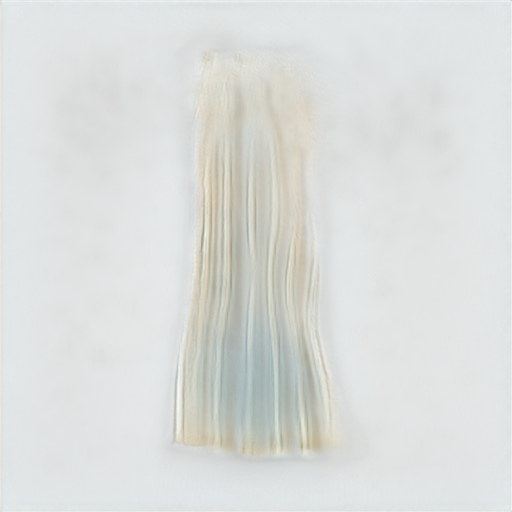

In [9]:
tensor2im(out_img[0,:,:,:])

In [10]:
latent.shape

torch.Size([1, 16, 512])

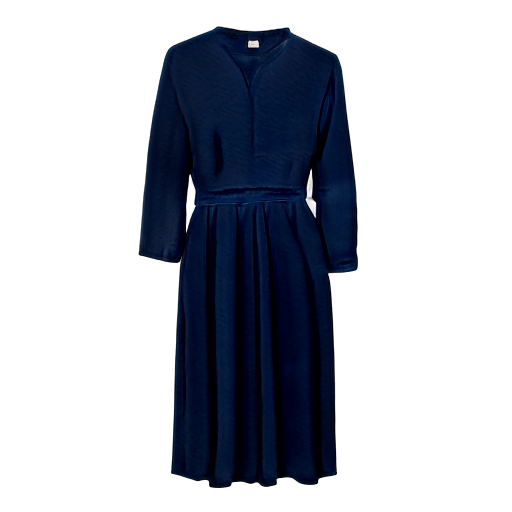

In [36]:
sample_z = torch.randn(16, 512, device='cuda').reshape(1,16,512)
out,_ = generator(sample_z)
tensor2im(out[0,:,:,:])